# including code

In [1]:
pathtosrc="../src";

### for the PL Integration methods

In [2]:
include(pathtosrc*"/header/PLIntegration2D/PLIntegration2D.jl");

### external packages

In [3]:
using Sobol
using NLsolve
using QuadGK
using LinearAlgebra
using Integrals
using FiniteDiff
using StaticArrays
using Contour
using Peaks
using DataFrames
using ForwardDiff
using Interpolations

In [4]:
using GLMakie # for plotting

### my definitions of the setup

In [5]:
# include("../src/header/includes.jl"); # at some point I could put all the includes in here

In [6]:
include(pathtosrc*"/header/utils.jl")
include(pathtosrc*"/header/beams.jl");
include(pathtosrc*"/header/saddles.jl");
[include(pathtosrc*"/header/Beams/"*fn) for fn in readdir(pathtosrc*"/header/Beams/")]
include(pathtosrc*"/header/equations.jl");
include(pathtosrc*"/header/ionisationbursts.jl");
include(pathtosrc*"/header/harmonic-response.jl");

In [7]:
### just for convenience
function action_functions(b::Beam, Ip::Number, q::Number)
    
    action(ti, tr) = -im*S(b, Ip, ti, tr, q)
    action_grad(ti, tr) = -1im .* [dS_dti(b,Ip,q,ti,tr); dS_dtr(b,Ip,q,ti,tr)]
    action_hessian(ti,tr) = my_hessian(b, Ip, q, ti, tr)
    
    return action, action_grad, action_hessian
end

action_functions (generic function with 1 method)

# laser field definition

The "tunnelling-without-barrier" scenario (as in our paper) is just any field composed of the two frequencies $\omega$ and $2 \omega$, with equal intensities and $\pi/2$ phase shift between them.

In [8]:
I0_base = 2e14;
I0 = 2e14;
λ = 800;

### convenience function to make different beams

In [9]:
# function to recturn a beam struct for a given intensity
function beam_I0(I0::Float64)
    λ = 800;
    BeamBETC(Intensity1 = I0, Intensity2 = I0, lambda=λ, r=1, s=2, epsilon = 0., phi = π/2)
end

beam_I0 (generic function with 1 method)

In [10]:
beam_twob = BeamBETC(Intensity1 = I0, Intensity2 = I0, lambda=λ, r=1, s=2, epsilon = 0., phi = π/2)

BeamTC(0.07559289460184544, 0.07559289460184544, 0.056939529014612654, 0.11387905802922531, 0.0, 0.0, 1.5707963267948966)

In [14]:
#=let 
    b = BeamBETC(Intensity1 = 0., Intensity2 = 1e14, lambda=λ, r=1, s=2, epsilon = 0., phi = π/2)
    
    TC = TCycle(b)

    ib_lims = get_ionisationburst_limits(b, Ip)
end=#

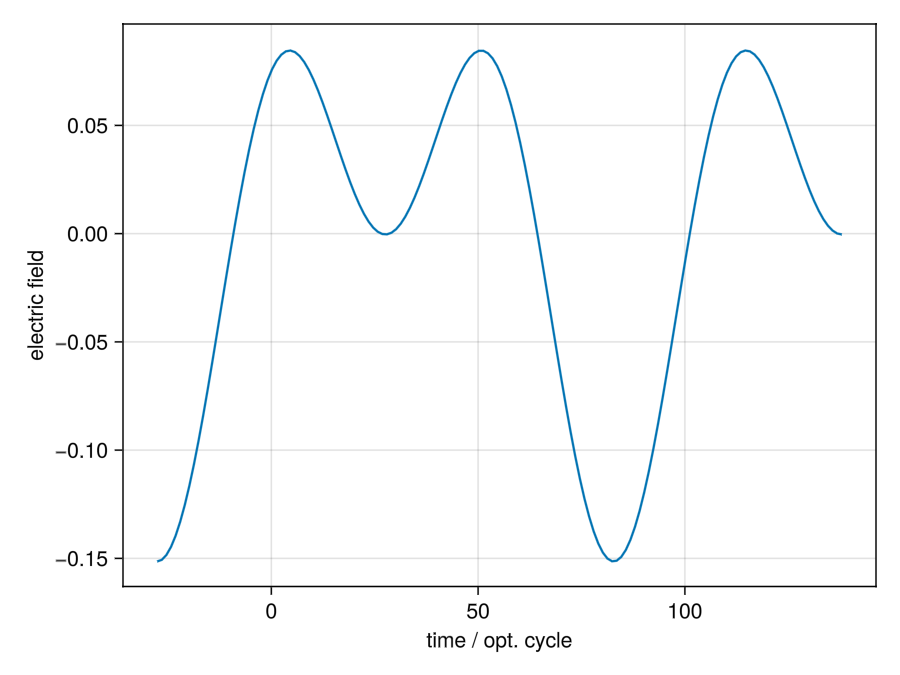

In [11]:
# plot the field shape
let # local scope block
    beam = beam_I0(2e14)
    
    TC = TCycle(beam) # 1 optical cycle = 2π/ω
    times = range(-0.25TC, stop = 1.25*TC, length = 150)
    
    efield = [E(beam)(t)[1] for t in times]
    
    f = Figure()
    ax = Axis(f[1, 1],
        xlabel = "time / opt. cycle",
        ylabel = "electric field"
    ) 
    
    lines!(ax, times, efield)

    f
end

# target

This code is for hydrogenic targets only, and we're working within the SFA, so all we use to describe the target is its ionisation potential `Ip`, in atomic units.

In [12]:
const Ip = IpAU(15.7596) # Argon gas target, we will keep this constant

0.5791543250255408

In case you want to look at the classical solutions you can set $I_p = 0$.

In [13]:
const Ip_class = 0.0;

# preliminary considerations for the setup

### Keldysh parameter

<div class="alert alert-warning">
Note: Check that the Keldysh parameter $\gamma$ for your setup is <1.
</div>

In [14]:
get_omega(λ)*sqrt(2*Ip/(I0/IAU))

0.8106717602290898

### Harmonic orders

minimal harmonic order should be (slightly above) the threshold harmonic:

In [15]:
HO_min = Ip/get_omega(λ) # 1030 nm fundamental wavelength

10.171392968089176

maxmimal harmonic order can be easy 30% above the classical cutoff order:

In [16]:
HO_max = (Ip + 3.17*get_Up(beam_I0(I0_base)))/get_omega(λ)

40.835450690258654

In [17]:
q_values = collect( (round(HO_min+1)) : (1.4*round(HO_max)) );

# classification code

## structs

In [18]:
struct ClassifiedSaddle
    s::Saddle
    tag::Int
    relevant::Bool
end

In [19]:
struct ClassifiedDipole
    q::Number
    dip::Vector{ComplexF64}
    tag::Int
    relevant::Bool
    int::Float64
end

## functions

### trace_saddle_across_q()

In [20]:
function trace_saddle_across_q(s::Saddle, qmin::Number, qmax::Number;
        b::Beam, Ip::Real, qstep::Number=1.,
        beam::Beam=b )
    
    ### now iterate to above
    s_init = s
    q_init = s.q
    saddles = [s_init] # better julia would be to define that array beforehand and then just fill it
    
    TC = TCycle(b)
    
    ### to above
    for q in range(q_init, stop = qmax, step = qstep)
        seed = saddles[end]
        ti_domain = ComplexDomain(real(seed.ti)/TC - 0.2, real(seed.ti)/TC + 0.2, 0.01,0.35)*TC;
        tr_domain = ComplexDomain(real(seed.tr)/TC - 0.3, real(seed.tr)/TC + 0.3, -0.35,0.35)*TC;
        next = find_saddle_similar_seed(q, seed, b=beam, Ip=Ip, ti_cd = ti_domain, tr_cd = tr_domain)
        push!(saddles, next)
    end
    push!(saddles, s_init)
    
    ### to below
    for q in range(q_init, stop = qmin, step = -qstep)
        seed = saddles[end]
        ti_domain = ComplexDomain(real(seed.ti)/TC - 0.2, real(seed.ti)/TC + 0.2, 0.01,0.35)*TC;
        tr_domain = ComplexDomain(real(seed.tr)/TC - 0.3, real(seed.tr)/TC + 0.3, -0.35,0.35)*TC;
        next = find_saddle_similar_seed(q, seed, b=beam, Ip=Ip, ti_cd = ti_domain, tr_cd = tr_domain)
        push!(saddles, next)
    end
    deleteat!(saddles, 1)
    sort!(saddles, by = s -> s.q)

    saddles   
end

trace_saddle_across_q (generic function with 1 method)

### get_classified_saddles()

In [21]:
function get_classified_saddles(beam::Beam, Ip::Number, q_values::Vector{T};
        ionisationbursts::Vector{Tuple{Float64, Float64}} = get_ionisationburst_limits(beam, Ip, q_values),
        q_init::Real=q_values[Int(round(length(q_values)/2))],
        calculate_relevance::Bool=true
        ) where T<:Real
    
    TC = TCycle(beam)
    
    data = Vector{ClassifiedSaddle}()
    for (ib, lims) in enumerate(ionisationbursts)
        
        ### for q_init (~ a harmonic order in the plateau), find all saddle points from this IB
        
        ti_domain = ComplexDomain(lims[1], lims[2], 0.01,0.35)*TC;
        tr_domain = ComplexDomain(lims[1]+0.1, lims[2] + 1., -0.35,0.35)*TC;
        saddles = find_saddles_sobol(q_init; b = beam, Ip = Ip,ti_cd=ti_domain, tr_cd=tr_domain)
        
        ### select those with reasonable travel time
        saddles_init = sort(
            filter(s -> in(real(traveltime(s)), 0.2*TC,  1*TC) &&
                in(real(s.ti)/TC, lims...),
                saddles)
            , by = s -> real(traveltime(s)) )
        
        @assert length(saddles_init) == 6
        
        ### for each of the saddles, find saddles for the remaining harmonic orders
        for (idx, s_init) in enumerate(saddles_init)
            tag = ib*10 + idx # this is now my naming convention for the tag of each trajectory

            saddles_trace = trace_saddle_across_q(s_init, extrema(q_values)..., b = beam, Ip = Ip)

            for s in saddles_trace
                if calculate_relevance
                    rel = check_contribution(action_functions(beam, Ip, s.q)..., s.ti, s.tr)
                    push!(data, ClassifiedSaddle(s, tag, rel))
                else
                    push!(data, ClassifiedSaddle(s, tag, false))
                end

            end
        end

    end
    data
end

get_classified_saddles (generic function with 1 method)

### get_classified_dipoles()

In [28]:
function get_classified_dipoles(beam::Beam, Ip::Number, q_values::Vector{T},
        classified_saddles::Vector{ClassifiedSaddle}) where T<:Real
    
    TC = TCycle(beam)

    function prefactor(ti,tr)
        ### eq. 5 from Emilio's thc paper
        ps = p_stationary(beam, ti, tr)
        dip_r = dipole_SR_conj(ps .+ A(beam)(tr), Ip)

        fontaine_SR_m0 = 1 / (kappa(Ip) * sqrt(2) * π)
        traveltime = tr - ti

        prefactor_const = (2*π/(im*traveltime))^(3/2) # spreading factor
        prefactor_const *= fontaine_SR_m0

        return prefactor_const * dip_r
    end
    
    
    data = Vector{ClassifiedDipole}()
    
    for q in q_values
        S_f, S_grad, S_hessian = action_functions(beam, Ip, q)

        saddles_q = filter(cs-> cs.s.q == q, classified_saddles)
    
        for cs in saddles_q
            dip_s = saddles_gaussian_contribution(S_f, S_hessian, cs.s.ti, cs.s.tr, prefactor = prefactor)
            intensity = harmonic_intensity(beam, dip_s, cs.s.q)
            push!(data, ClassifiedDipole(cs.s.q, dip_s, cs.tag, cs.relevant, intensity))
        end 
    end
    data 
end

get_classified_dipoles (generic function with 1 method)

## plotting utilities

In [22]:
tag_colours = let
    ### expected number of saddles per IB
    ns = 6
    ### number of ionisationbursts
    ni = 4
    
    tags = [i*10+j for i in 1:ni for j in 1:ns]
#     @show tags
    collength = ns+1
    colmap = :lightrainbow # find colormaps here: https://docs.makie.org/stable/explanations/colors
    tag_colours = Dict([(tag, cgrad(colmap, collength, categorical = true)[tag%10]) 
            for tag in tags])
    for t in setdiff(1:50, tags) # all other occuring tags
        tag_colours[t] = Makie.to_color(:grey)
    end
    tag_colours
end;

In [23]:
### these will be the colours
cgrad(:lightrainbow, 7, categorical = true)

# explanations/walkthrough for the classification

## all saddle points, unstructured, just for demonstration

In [58]:
# this might take a while
test_data_all = let 
    b = beam_I0(I0_base)
    
    TC = TCycle(b)
    all = Vector{Tuple{Saddle,Bool}}()

    ib_lims = get_ionisationburst_limits(b, Ip, q_values)

    for (idx,lims) in enumerate(ib_lims)
        
        ti_domain = ComplexDomain(lims[1], lims[2], 0.01,0.35)*TC;
        tr_domain = ComplexDomain(lims[1]+0.1, lims[2] + 1., -0.35,0.35)*TC;
        
        results = [Vector{Vector}() for _ in 1:Threads.nthreads()]

        Threads.@threads for q in q_values[1:40]
            data_thread = Vector{Tuple{Saddle,Bool}}()
            
            saddles = find_saddles_sobol(q; b = b, Ip = Ip,ti_cd=ti_domain, tr_cd=tr_domain)
            for s in saddles
                rel = check_contribution(action_functions(b, Ip, q)..., s.ti, s.tr)
                ### if you want to save time, just do this instead
                # rel = true 

                push!(data_thread, (s, rel))
            end        

            push!(results[Threads.threadid()], data_thread)
        end

        [[push!(all, vec...) for vec in r] for r in results]
    end

    all
end;

┌ Warning: I'm hitting the integration plane more than once I think
└ @ Main C:\Users\juder\Documents\Third Year Project\HHGsimPL.jl-user\src\header\PLIntegration2D\saddles-contributing.jl:36
┌ Warning: I'm hitting the integration plane more than once I think
└ @ Main C:\Users\juder\Documents\Third Year Project\HHGsimPL.jl-user\src\header\PLIntegration2D\saddles-contributing.jl:36
┌ Warning: Warning (3)! The necklace is smaller than its initialisation, real(f) = -0.21045500779174375
└ @ Main C:\Users\juder\Documents\Third Year Project\HHGsimPL.jl-user\src\header\PLIntegration2D\necklace-for-SA-thimble.jl:251


In [270]:
scr1 = GLMakie.Screen();

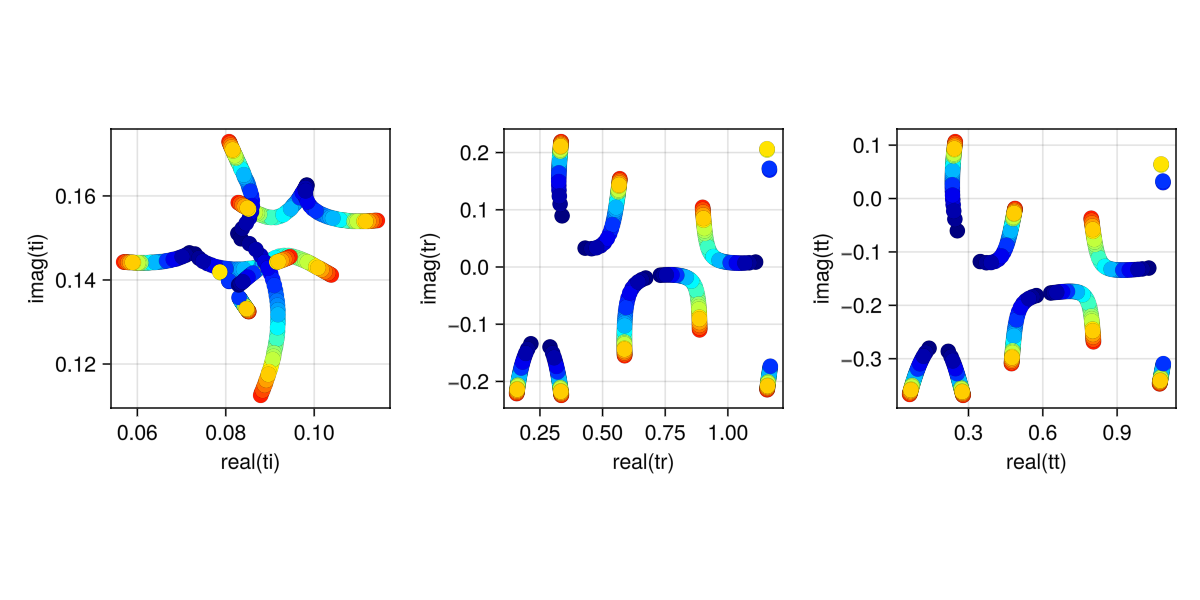

In [282]:
let
    b = beam_I0(I0_base)
    ionisationbursts = get_ionisationburst_limits(b, Ip, q_values)   
    TC = TCycle(b)

    data = test_data_all
    ### if you want to only look at one ionisationburst you can do this instead:
     ib = 1 # e.g. first ionisationburst
     data = filter(tup -> in(real(tup[1].ti/TC ), ionisationbursts[ib]... ), test_data_all)


    fig = Figure(size = (800,400))
    ax1 = Axis(fig[1, 1],  xlabel = "real(ti)", ylabel = "imag(ti)", aspect=1) 
    ax2 = Axis(fig[1, 2],  xlabel = "real(tr)", ylabel = "imag(tr)", aspect=1) 
    ax3 = Axis(fig[1, 3],  xlabel = "real(tt)", ylabel = "imag(tt)", aspect=1) 
    
    # ti in the complex plane
    [scatter!(ax1, [(real(tup[1].ti)/TC, imag(tup[1].ti)/TC)],
            color = tup[2] ? real(tup[1].q) : :transparent,
            markersize = 15, 
            strokecolor = tup[2] ? :transparent : :grey,
            strokewidth = 1,
            colorrange = extrema(q_values), colormap = :jet) for tup in data]
    
    [scatter!(ax2, [reim(tup[1].tr)./TC],
            color = tup[2] ? real(tup[1].q) : :transparent,
            markersize = 15, 
            strokecolor = tup[2] ? :transparent : :grey,
            strokewidth = 1,
            colorrange = extrema(q_values), colormap = :jet) for tup in data]
    
    [scatter!(ax3, [reim(tup[1].tr - tup[1].ti)./TC],
            color = tup[2] ? real(tup[1].q) : :transparent,
            markersize = 15, 
            strokecolor = tup[2] ? :transparent : :grey,
            strokewidth = 1,
            colorrange = extrema(q_values), colormap = :jet) for tup in data]    
    
    #display(scr1, fig) # plot them onto an extra window 
     fig # plot here in the jupyter notebook
      
end

## getting classified saddles

In [24]:
### (calculating the relevance might take a while)
test_classified_saddles = get_classified_saddles(beam_twob, Ip, q_values, calculate_relevance=false)

1176-element Vector{ClassifiedSaddle}:
 ClassifiedSaddle(ti: 10.52 + 14.3im, tr: 36.5 + 8.93im, q11.0, 11, false)
 ClassifiedSaddle(ti: 10.72 + 14.19im, tr: 35.8 + 10.96im, q12.0, 11, false)
 ClassifiedSaddle(ti: 10.86 + 14.06im, tr: 35.54 + 12.32im, q13.0, 11, false)
 ClassifiedSaddle(ti: 10.98 + 13.91im, tr: 35.42 + 13.35im, q14.0, 11, false)
 ClassifiedSaddle(ti: 11.08 + 13.77im, tr: 35.38 + 14.17im, q15.0, 11, false)
 ClassifiedSaddle(ti: 11.15 + 13.62im, tr: 35.38 + 14.85im, q16.0, 11, false)
 ClassifiedSaddle(ti: 11.22 + 13.48im, tr: 35.4 + 15.44im, q17.0, 11, false)
 ClassifiedSaddle(ti: 11.27 + 13.35im, tr: 35.43 + 15.95im, q18.0, 11, false)
 ClassifiedSaddle(ti: 11.31 + 13.22im, tr: 35.47 + 16.4im, q19.0, 11, false)
 ClassifiedSaddle(ti: 11.34 + 13.09im, tr: 35.51 + 16.8im, q20.0, 11, false)
 ClassifiedSaddle(ti: 11.37 + 12.96im, tr: 35.55 + 17.17im, q21.0, 11, false)
 ClassifiedSaddle(ti: 11.39 + 12.84im, tr: 35.59 + 17.5im, q22.0, 11, false)
 ClassifiedSaddle(ti: 11.4 + 12.7

In [256]:
(test_classified_saddles[1])

ClassifiedSaddle(ti: 9.96 + 15.2im, tr: 36.85 + 9.31im, q11.0, 11, true)

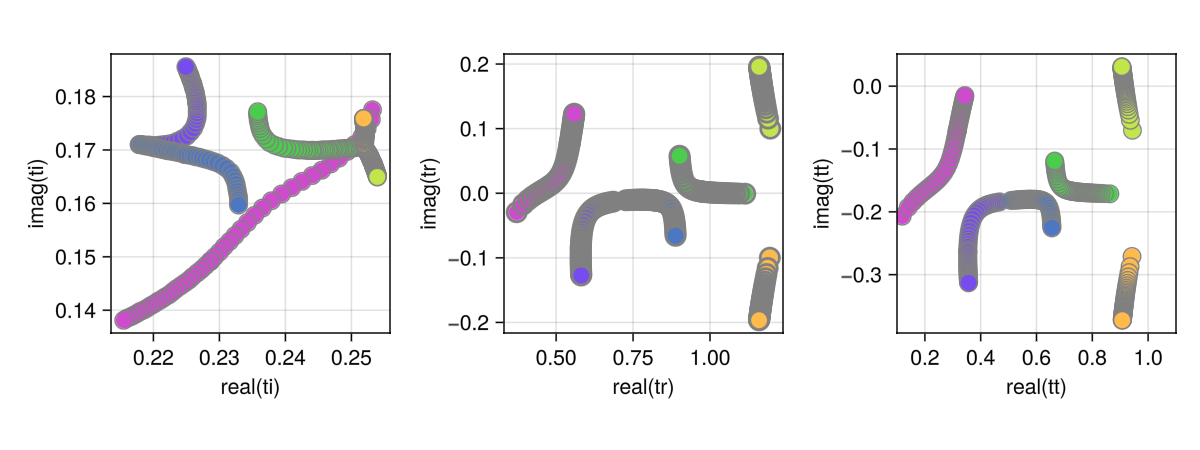

In [25]:
let
    b = beam_I0(I0_base)
    TC = TCycle(b)

    fig = Figure(size = (800, 300))
        
    ib = 2 # which ionisation burst
    data_cs = filter(cs -> div(cs.tag, 10) == ib , test_classified_saddles)
    
    ax1 = Axis(fig[1, 1],  xlabel = "real(ti)", ylabel = "imag(ti)", aspect=1) 
    ax2 = Axis(fig[1, 2],  xlabel = "real(tr)", ylabel = "imag(tr)", aspect=1) 
    ax3 = Axis(fig[1, 3],  xlabel = "real(tt)", ylabel = "imag(tt)", aspect=1) 

    ### colour according to tag or to harmonic order
     # color_cs(cs::ClassifiedSaddle) = cs.relevant ? real(cs.s.q) : :transparent
    color_cs(cs::ClassifiedSaddle) = tag_colours[cs.tag]

    # ionisation times
    [scatter!(ax1, [(real(cs.s.ti)/TC, imag(cs.s.ti)/TC)],
            color = color_cs(cs),
            markersize = 15, 
            strokecolor = cs.relevant ? :transparent : :grey,
            strokewidth = 1,
            colorrange = extrema(q_values), colormap = :jet) for cs in data_cs]

    # recombination times
    [scatter!(ax2, [reim(cs.s.tr)./TC],
            color = color_cs(cs),
            markersize = 15, 
            strokecolor = cs.relevant ? :transparent : :grey,
            strokewidth = 2,
            colorrange = extrema(q_values), colormap = :jet) for cs in data_cs]

    # travel times
    [scatter!(ax3, [reim(cs.s.tr - cs.s.ti)./TC],
            color = color_cs(cs),
            markersize = 15, 
            strokecolor = cs.relevant ? :transparent : :grey,
            strokewidth = 1,
            colorrange = extrema(q_values), colormap = :jet) for cs in data_cs]    
    
    xlims!(ax3, 0.1, 1.1)
    
    fig
    # display(scr1, fig)    
end

## calculate dipole for one given harmonic order

In [26]:
let
    q = 29.
    b = beam_twob

    S_f, S_grad, S_hessian = action_functions(b, Ip, q)
    
    function prefactor(ti,tr)
        ### eq. 5 from Emilio's thc paper
        ps = p_stationary(b, ti, tr)
        dip_r = dipole_SR_conj(ps .+ A(b)(tr), Ip)
        
        fontaine_SR_m0 = 1 / (kappa(Ip) * sqrt(2) * π)
        traveltime = tr - ti

        prefactor_const = (2*π/(im*traveltime))^(3/2) # spreading factor
        prefactor_const *= fontaine_SR_m0

        return prefactor_const * dip_r
    end

    ### find the respective saddles in the big data array of classified saddles
    saddles_q = filter(cs-> cs.s.q == q, test_classified_saddles)
    
    int_spm = zeros(ComplexF64,2) # sum over gaussian contributions
    
    for cs in saddles_q
        println("saddle: ", cs.s)
        @show cs.relevant
        if cs.relevant
            int_spm_s = saddles_gaussian_contribution(S_f, S_hessian, cs.s.ti, cs.s.tr, prefactor = prefactor)
            int_spm .+= int_spm_s
            
            @show int_spm_s
            println()
        end
    end
    @show int_spm
end

saddle: ti: 11.42 + 12.1im, tr: 35.88 + 19.24im, q29.0
cs.relevant = false
saddle: ti: 8.41 + 13.48im, tr: 35.77 - 20.36im, q29.0
cs.relevant = false
saddle: ti: 10.81 + 16.22im, tr: 60.02 + 8.04im, q29.0
cs.relevant = false
saddle: ti: 12.97 + 15.79im, tr: 64.92 - 8.03im, q29.0
cs.relevant = false
saddle: ti: 12.29 + 16.2im, tr: 88.4 - 1.34im, q29.0
cs.relevant = false
saddle: ti: 11.13 + 13.66im, tr: 110.63 + 0.63im, q29.0
cs.relevant = false
saddle: ti: 25.64 + 16.99im, tr: 59.19 + 6.48im, q29.0
cs.relevant = false
saddle: ti: 25.01 + 19.45im, tr: 64.31 - 7.24im, q29.0
cs.relevant = false
saddle: ti: 24.61 + 18.73im, tr: 88.87 - 1.15im, q29.0
cs.relevant = false
saddle: ti: 27.13 + 18.76im, tr: 109.76 + 0.17im, q29.0
cs.relevant = false
saddle: ti: 27.95 + 18.48im, tr: 128.83 + 18.81im, q29.0
cs.relevant = false
saddle: ti: 27.81 + 19.18im, tr: 128.76 - 18.89im, q29.0
cs.relevant = false
saddle: ti: 53.94 + 11.21im, tr: 83.03 - 0.49im, q29.0
cs.relevant = false
saddle: ti: 45.67 + 1

2-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im

## getting classified dipoles

In [27]:
test_classified_dipoles = get_classified_dipoles(beam_twob, Ip, q_values, test_classified_saddles)

LoadError: UndefVarError: `get_classified_dipoles` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## plot the full spectrum

In [28]:
let
    beam = beam_I0(I0_base)
    data_dipoles = test_classified_dipoles
    

    
    f = Figure(size=(800,400))
    ax = Axis(f[1, 1], 
        yscale = log10, 
        xlabel = "harmonic order", ylabel = "harmonic intensity" ) 
    
    ### for each tag separately
    tags = unique([cd.tag for cd in data_dipoles])
    
    for tag in tags
        data_tag = sort(filter(cd -> cd.tag == tag, data_dipoles), by = cd -> cd.q)
        
        scatterlines!(ax, [(cd.q, cd.int) for cd in data_tag]
            , color = [cd.relevant ? tag_colours[tag] : :grey 
                for cd in data_tag] )
    end
    
    ### summing all the contributions from all the relevant dipoles (NOTE! coherent summation!)
    total_intensity = [
        harmonic_intensity(beam,
            ### dipole
            sum([cd.dip for cd in
            filter(cd-> cd.relevant && cd.q ==q, data_dipoles) # relevant dipoles for this q
            ]), q)
        for q in q_values
    ]
    
#     @show total_intensity
    scatterlines!(ax, q_values, total_intensity, color = :black)
    
    ylims!(ax, (1e-20,1e-11))

#     f[1,2] = Legend(f, ax)
    f
end

LoadError: UndefVarError: `test_classified_dipoles` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# do intensity scan

In [49]:
IBs = get_ionisationburst_limits(beam_I0(2e14), Ip)
tags = [i*10+j for i in 1:4 for j in 1:6]
tag_index = Dict(tag => idx for (idx, tag) in enumerate(tags))

I0_values = range(1e14, stop = 5e14, length=20)
data_real = Array{Float64}(undef, length(I0_values), 4*6, length(q_values))
data_imag = Array{Float64}(undef, length(I0_values), 4*6, length(q_values))

for (i, I0) in enumerate(I0_values)
    beam = beam_I0(I0)
    test_classified_saddles = get_classified_saddles(beam, Ip, q_values, calculate_relevance=false, ionisationbursts=IBs)
   for cs in test_classified_saddles
        S_f, S_grad, S_hessian = action_functions(beam, Ip, cs.s.q)
       # rel = check_contribution(action_functions(beam, Ip, s.q)..., s.ti, s.tr)
       # @show rel
        data_real[i,tag_index[cs.tag],Int(cs.s.q-10)] = real(S_f(cs.s.ti, cs.s.tr))
        data_imag[i,tag_index[cs.tag],Int(cs.s.q-10)] = imag(S_f(cs.s.ti, cs.s.tr))
   end
end

## plot the intensity scan

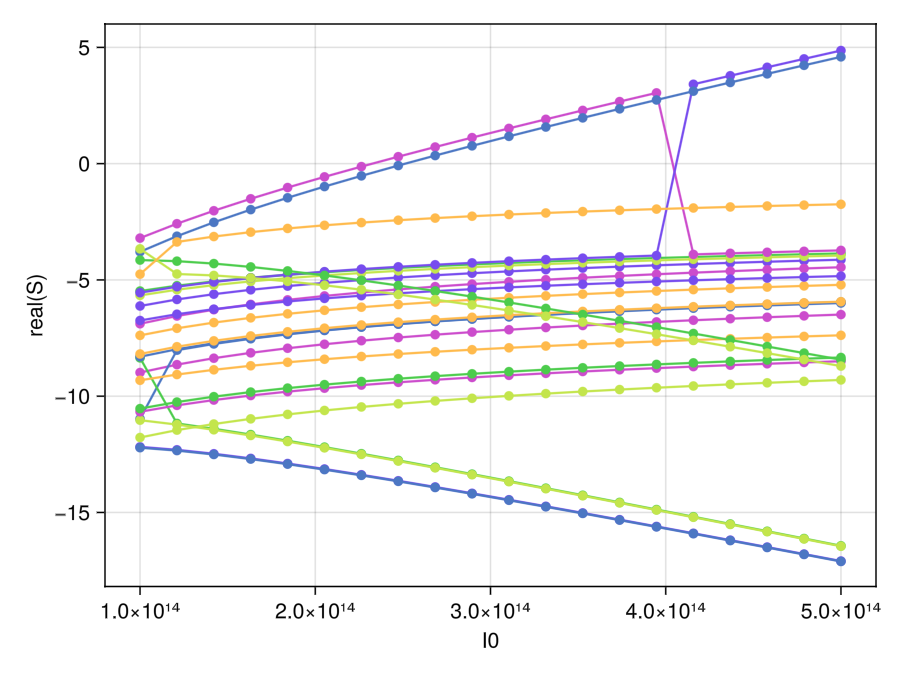

In [50]:
let
    f = Figure()
    ax = Axis(f[1, 1], xlabel = "I0", ylabel = "real(S)" )
    q_idx = 2
    #data_cs = filter(cs -> div(cs.tag, 10) == IBs , test_classified_saddles)
    color_cs(cs::ClassifiedSaddle) = tag_colours[cs.tag]
    for (i,tag) in enumerate(tags)
        [scatterlines!(ax, I0_values, data_real[:,i,q_idx], color = tag_colours[tag])]
    end
    f
end

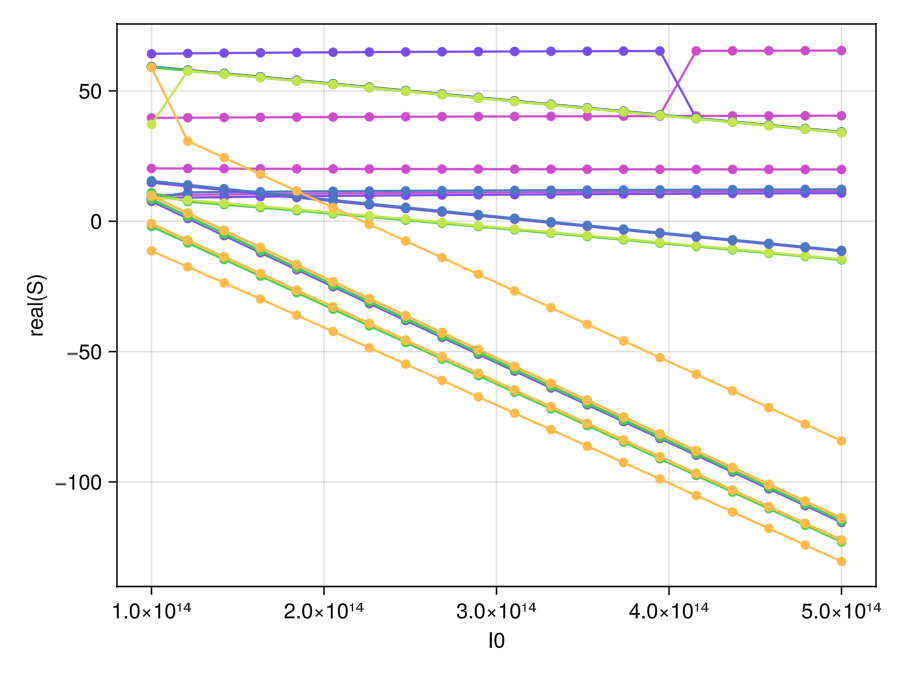

In [51]:
let
    f = Figure()
    ax = Axis(f[1, 1], xlabel = "I0", ylabel = "real(S)" )
    q_idx = 2
    #data_cs = filter(cs -> div(cs.tag, 10) == IBs , test_classified_saddles)
    color_cs(cs::ClassifiedSaddle) = tag_colours[cs.tag]
    for (i,tag) in enumerate(tags)
        [scatterlines!(ax, I0_values, data_imag[:,i,q_idx], color = tag_colours[tag])]
    end
    
    f
end

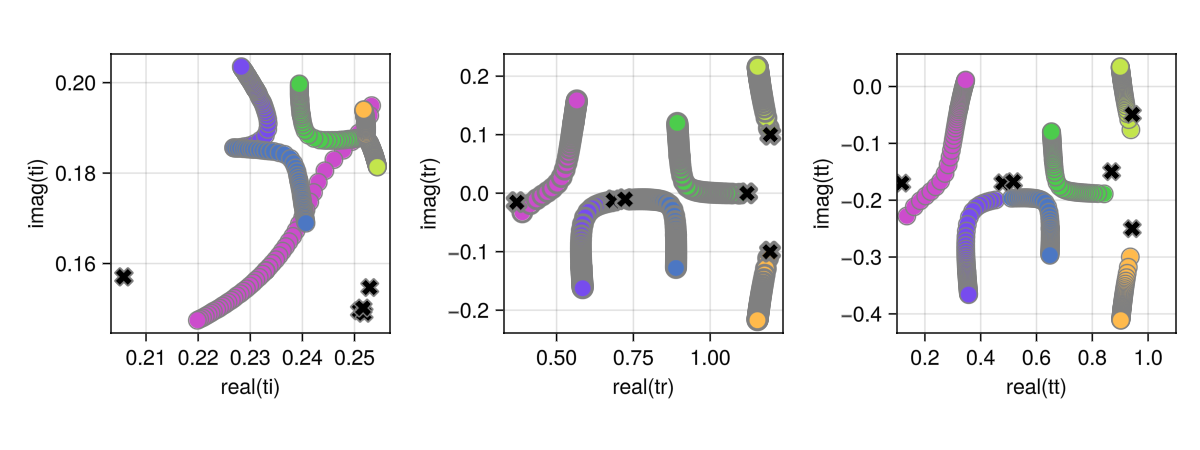

In [ ]:
let
    b = beam_I0(1e14)
    TC = TCycle(b)

    fig = Figure(size = (800, 300))
        
    ib = 2# which ionisation burst
    data_cs = filter(cs -> div(cs.tag, 10) == ib , get_classified_saddles(b, Ip, q_values, calculate_relevance=false, ionisationbursts=IBs))
    
    ax1 = Axis(fig[1, 1],  xlabel = "real(ti)", ylabel = "imag(ti)", aspect=1) 
    ax2 = Axis(fig[1, 2],  xlabel = "real(tr)", ylabel = "imag(tr)", aspect=1) 
    ax3 = Axis(fig[1, 3],  xlabel = "real(tt)", ylabel = "imag(tt)", aspect=1) 

    ### colour according to tag or to harmonic order
     # color_cs(cs::ClassifiedSaddle) = cs.relevant ? real(cs.s.q) : :transparent
    color_cs(cs::ClassifiedSaddle) = tag_colours[cs.tag]

    # ionisation times
    [scatter!(ax1, [(real(cs.s.ti)/TC, imag(cs.s.ti)/TC)],
            color = color_cs(cs),
            markersize = 15, 
            strokecolor = cs.relevant ? :transparent : :grey,
            strokewidth = 1,
            colorrange = extrema(q_values), colormap = :jet) for cs in data_cs]

    # recombination times
    [scatter!(ax2, [reim(cs.s.tr)./TC],
            color = color_cs(cs),
            markersize = 15, 
            strokecolor = cs.relevant ? :transparent : :grey,
            strokewidth = 2,
            colorrange = extrema(q_values), colormap = :jet) for cs in data_cs]

    # travel times
    [scatter!(ax3, [reim(cs.s.tr - cs.s.ti)./TC],
            color = color_cs(cs),
            markersize = 15, 
            strokecolor = cs.relevant ? :transparent : :grey,
            strokewidth = 1,
            colorrange = extrema(q_values), colormap = :jet) for cs in data_cs]    

    ### highlight one specific harmonic order
    data_special_q =  filter(cs -> div(cs.tag, 10) == ib && cs.s.q == 12
        , test_classified_saddles)
 [scatter!(ax1, [(real(cs.s.ti)/TC, imag(cs.s.ti)/TC)],
            color = :black, marker = :x,
            markersize = 15, 
            strokecolor = cs.relevant ? :transparent : :grey,
            strokewidth = 1,
            colorrange = extrema(q_values), colormap = :jet) for cs in data_special_q]

    # recombination times
    [scatter!(ax2, [reim(cs.s.tr)./TC],
            color = :black, marker = :x,
            markersize = 15, 
            strokecolor = cs.relevant ? :transparent : :grey,
            strokewidth = 2,
            colorrange = extrema(q_values), colormap = :jet) for cs in data_special_q]

    # travel times
    [scatter!(ax3, [reim(cs.s.tr - cs.s.ti)./TC],
            color = :black, marker = :x,
            markersize = 15, 
            strokecolor = cs.relevant ? :transparent : :grey,
            strokewidth = 1,
            colorrange = extrema(q_values), colormap = :jet) for cs in data_special_q]    
    
    xlims!(ax3, 0.1, 1.1)
    
    fig
    # display(scr1, fig)    
end

## plot derivative

In [100]:
let
    f = Figure()
    ax = Axis(f[1, 1], xlabel = "I0", ylabel = "d real(S) / d I0" ) 
       
    for (i,tag) in enumerate(tags)
    #    scatterlines!(ax, I0_values, data[:,i], colour = tag_colours[cs.tag])
        scatterlines!(ax, I0_values, data1[:,i])
    end
#     ylims!(ax, (-75, 75)) ### adjust the y axis limits
    
    f
end

LoadError: UndefVarError: `data1` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [224]:
#g(x) = 3 * x[1]^2
#g([1])
#ForwardDiff.gradient(g,[1])
#for (i, I0) in enumerate(I0_values)
#    ForwardDiff.gradient(data[:,i],I0_values)
#end
#
#itp = interpolate(I0_values, data)
#itp(1.5e14)
intensity_values = Array{Float64}(undef, length(I0_values), 4*6)
#for (i, I0) in enumerate(I0_values)
#    itp = interpolate(i, data[:,i])
#end

for (i,tag) in enumerate(tags)
    @show i
#end


enumerate(tags) = enumerate([11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 36, 41, 42, 43, 44, 45, 46])


enumerate([11, 12, 13, 14, 15, 16, 21, 22, 23, 24  …  33, 34, 35, 36, 41, 42, 43, 44, 45, 46])

In [205]:
function deriv(data::Matrix{Float64},I0_values::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64})
    function centraldiff(v::AbstractVector)
        dv  = diff(v)/2 # half the derivative
        a   = [dv[1];dv] # copies first element
        a .+= [dv;dv[end]] # copies last element, add both results to compute average
        return(a)
    end
    return  centraldiff(data)./centraldiff(I0_values)
end
deriv(data,I0_values)

LoadError: MethodError: no method matching (::var"#centraldiff#532")(::Matrix{Float64})
The function `centraldiff` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  (::var"#centraldiff#532")([91m::AbstractVector[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[205]:2[24m[39m
